In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from mpl_toolkits.mplot3d import Axes3D
from noisyopt import minimizeSPSA

In [3]:
np.random.seed(8138)

In [59]:
class Model():
    def __init__(self, pred_die=0.02, pred_repr=0.5, prey_repr=0.9, step_size = 100, mean_pred=500, mean_prey=1000):
        # grid dimensions
        self.width = 75
        self.height = 75
        
        # the values of different states of cells (containing predator, prey or none) 
        self.empty_val = 0
        self.pred_val = 1
        self.prey_val = 2
        
        self.pred_die_probability = pred_die
        self.pred_reproduce_probability = pred_repr
        self.prey_reproduce_probability = prey_repr
        self.step_size = step_size

        self.coordinates = []
        for y in range(self.height):
            for x in range(self.width):
                self.coordinates.append((y, x))
                
        self.error = 0
        
        # define starting population
        n_pred_start = 1500
        n_prey_start = 2*n_pred_start
        
        try: 
            (n_pred_start+n_prey_start) < self.width*self.height
        except ValueError:
            print("Population exceeds the gridsize")
        
        self.mean_pred = n_pred_start
        self.mean_prey = n_prey_start
        
        self.n_pred = n_pred_start
        self.n_prey = n_prey_start
        
        # init grid
        grid_flat = np.zeros(self.width*self.height)
        grid_flat[0:n_pred_start] = self.pred_val
        grid_flat[n_pred_start:n_pred_start+n_prey_start] = self.prey_val
        np.random.shuffle(grid_flat)
        self.grid = np.reshape(grid_flat, (self.height, self.width))
        
    def select_random_neighbor(self, coordinates):
        y = (coordinates[0] + (np.random.randint(3) - 1)) % self.height
        x = (coordinates[1] + (np.random.randint(3) - 1)) % self.width
        return (y, x)

    def step_grid(self):
        np.random.shuffle(self.coordinates)
        for coordinate in self.coordinates:
            value = self.grid[coordinate]
            if value == self.empty_val:
                continue
            else:
                neighbor_coordinate = self.select_random_neighbor(coordinate)
                neighbor_val = self.grid[neighbor_coordinate]
                if value == self.pred_val:
                    # predator
                    if neighbor_val == self.empty_val:
                        # die maybe
                        self.grid[coordinate] = self.empty_val
                        self.n_pred -= 1
                        if np.random.rand() > self.pred_die_probability:
                            # move (do not die)
                            self.grid[neighbor_coordinate] = self.pred_val
                            self.n_pred += 1
                    if neighbor_val == self.prey_val:                        
                        self.n_prey -= 1
                        if np.random.rand() < self.pred_reproduce_probability:
                            # eat and reproduce in prey's cell
                            self.grid[neighbor_coordinate] = self.pred_val
                            self.n_pred += 1
                        else:
                            # only eat prey
                            self.grid[neighbor_coordinate] = self.empty_val
                elif value == self.prey_val:
                    # prey
                    if neighbor_val == self.empty_val:
                        # (reproduce to/) move to new cell
                        self.grid[neighbor_coordinate] = self.prey_val
                        self.n_prey += 1
                        if np.random.rand() > self.prey_reproduce_probability:
                            # (do not reproduce/ kill old cell)
                            self.grid[coordinate] = self.empty_val
                            self.n_prey -= 1
                    if neighbor_val == self.pred_val:
                        self.n_prey -= 1
                        if np.random.rand() < self.pred_reproduce_probability:
                            # eat and reproduce to prey's cell
                            self.grid[coordinate] = self.pred_val
                            self.n_pred += 1
                        else:
                            # only eat prey
                            self.grid[coordinate] = self.empty_val

                            
    def run_model(self):
        pred_population = []
        prey_population = []
        for i in trange(self.step_size):
            pred_population.append(self.n_pred)
            prey_population.append(self.n_prey)
            if self.n_prey == 0 or self.n_pred == 0:
                break
            self.step_grid()
        plt.plot(pred_population, label="predators")
        plt.plot(prey_population, label="prey")
        plt.legend()
        self.objective_function((pred_population, prey_population))
        return (pred_population, prey_population)
    
    def run_of(self):
        pred_population = []
        prey_population = []
        for i in trange(self.step_size):
            pred_population.append(self.n_pred)
            prey_population.append(self.n_prey)
            if self.n_prey == 0 or self.n_pred == 0:
                break
            self.step_grid()
        plt.plot(pred_population, label="predators")
        plt.plot(prey_population, label="prey")
        plt.legend()
        plt.show()
        return self.objective_function((pred_population, prey_population))
    
#     def objective_function(self, time_series):
#         if len(time_series[0]) != self.step_size or len(time_series[1]) != self.step_size:
#             return 1000000000
#         mean_0 = np.mean(time_series[0])
#         mean_1 = np.mean(time_series[1])
#         cost = 0
#         for i in range(len(time_series[0])):
#             cost += (time_series[0][i] - mean_0)**2
#             cost += (time_series[1][i] - mean_1)**2
#         self.error = cost
#         return cost
    
    
    def objective_function(self, time_series):
        if len(time_series[0]) != self.step_size or len(time_series[1]) != self.step_size:
            return 5000
        pred_population = np.array(time_series[0][-150:])
        prey_population = np.array(time_series[1][-150:])
        cost = max(abs(prey_population-self.mean_prey)+abs(pred_population-self.mean_pred))
        self.error = cost
        return cost
        



[6, 7, 8]

[1890, 1894, 1772]

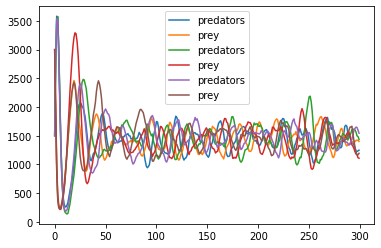

In [56]:
trials = 3
errors = []
for i in trange(trials):
    model = Model(1, 1, 1, 300)
    model.run_model()
    errors.append(model.error)
errors

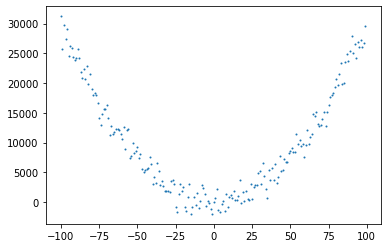

In [6]:
def func3(a, b, c):
    return a**2+b**2+c**2+np.random.normal(0, 1500, len(a))

x = np.arange(-100, 100, 1)
y = func3(x, x, x)

plt.plot(x, y, 'o', markersize=1)


In [7]:
cost_variability = []
for i in range(len(errors)):
    cost_variability.append(abs(1-(errors[i]/np.mean(errors))))
print(cost_variability)

[0.19337697854982983, 0.4318357880559859, 0.23845880950615594]


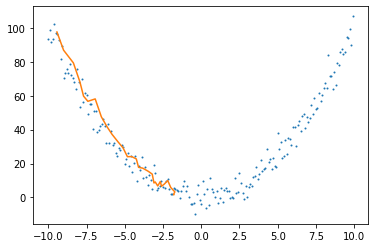

In [70]:
def func1_list(x):
    return x**2 + np.random.normal(0, 5, len(x)) 

def func1(x):
    return x**2+np.random.normal(0, 2) 

x = np.arange(-10, 10, 0.1)
y = func1_list(x)
plt.plot(x, y, 'o', markersize = 1)
# plt.show()
# hold on

def basic_robbins_monro(f, starting_point, n=30):
    x = starting_point
    x_list = []
    y_list = []
    h = 1
    for i in range(n):
        a = 1/n
        y = f(x)
        x = x-a*(f(x+h)-y)/h
        x_list.append(x)
        y_list.append(y)
    return x_list, y_list
        
x_list, y_list = basic_robbins_monro(func1, -10)
plt.plot(x_list, y_list)

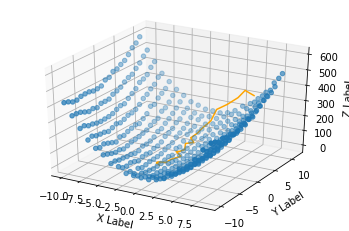

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def func1(x, y):
    return (2*x)**2+(y+5)**2+np.random.normal(0, 6) 

x_list = np.arange(-10, 10, 1)
y_list = np.arange(-10, 10, 1)

zs = []
xs = []
ys = []

for i in range(len(x_list)):
    for j in range(len(y_list)):
        xs.append(x_list[i])
        ys.append(y_list[j])
        zs.append(func1(x_list[i], y_list[j]))

ax.scatter(xs, ys, zs, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

def basic_robbins_monro_md(f, x1, x2, n=20):
    y = f(x1, x2)

    x1_list = [x1]
    x2_list = [x2]
    y_list = [y]
    
    h = 1
    
    for i in range(n):
        a = 1/n
        x1 = x1-a*(f(x1+h, x2)-y)/h
        x2 = x2-a*(f(x1, x2+h)-y)/h
        y = f(x1, x2)
        x1_list.append(x1)
        x2_list.append(x2)
        y_list.append(y)
    return x1_list, x2_list, y_list

xs, ys, zs = basic_robbins_monro_md(func1, 5, 10)
ax.plot(xs, ys, zs, color='orange')

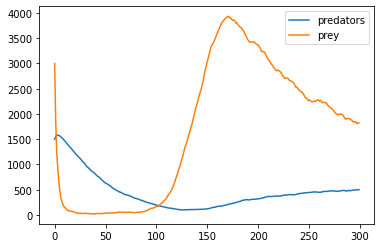

x1, x2, x3 error: 2229


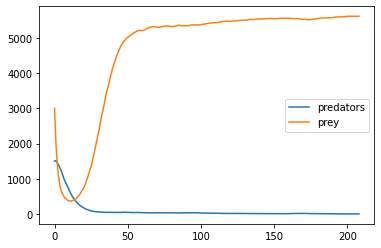

x1+h error: 5000


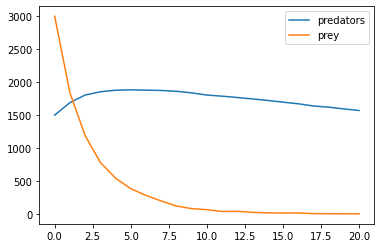

x2+h error: 5000


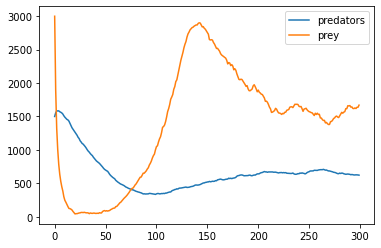

x3+h error: 2435
x1 random projection
x2 random projection
done running iteration


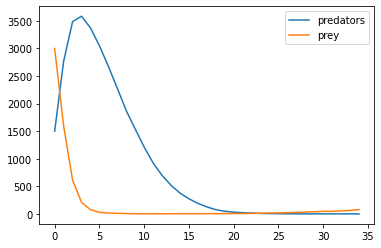

x1, x2, x3 error: 5000


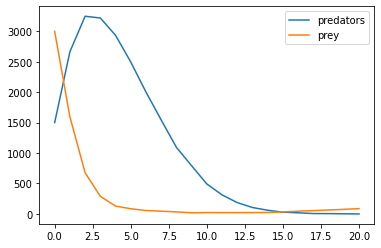

x1+h error: 5000


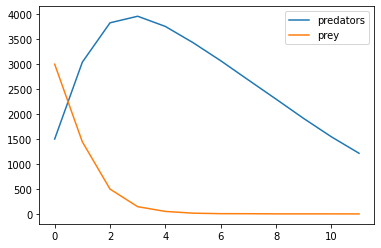

x2+h error: 5000


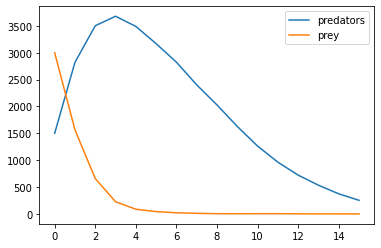

x3+h error: 5000
done running iteration


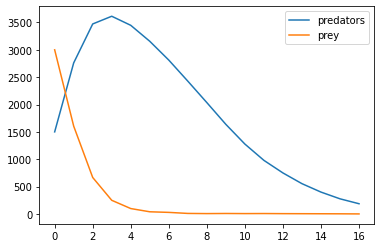

x1, x2, x3 error: 5000


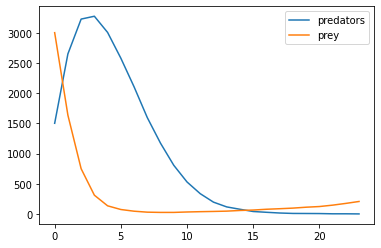

x1+h error: 5000


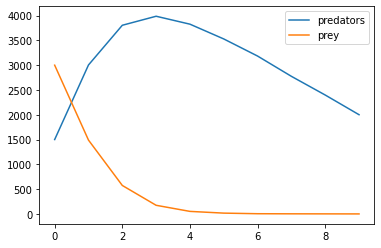

x2+h error: 5000


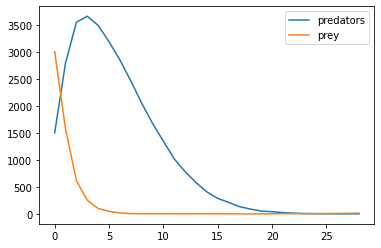

x3+h error: 5000
done running iteration


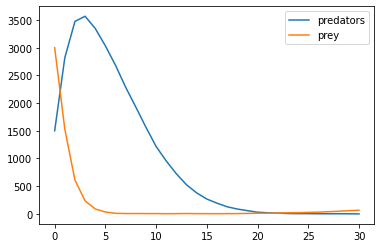

x1, x2, x3 error: 5000


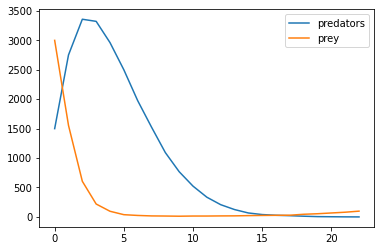

x1+h error: 5000


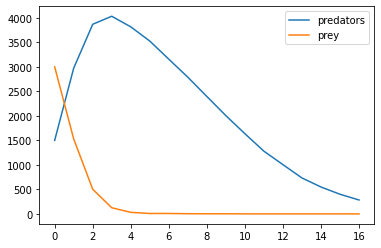

x2+h error: 5000


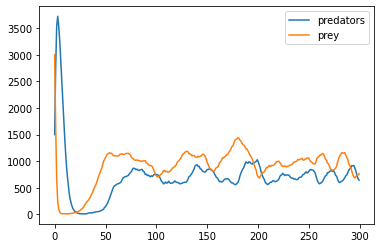

x3+h error: 3093
done running iteration


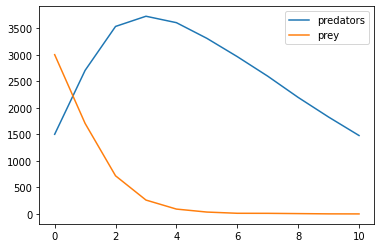

x1, x2, x3 error: 5000


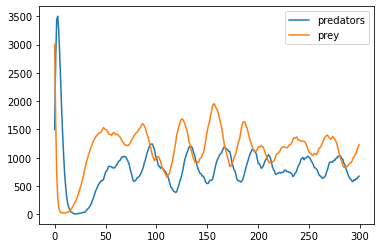

x1+h error: 2971


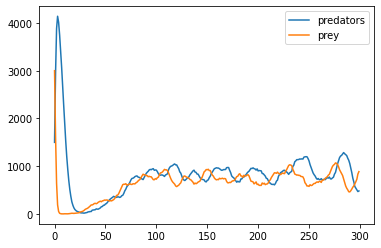

x2+h error: 3293


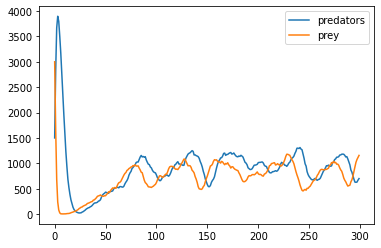

x3+h error: 3238
x2 random projection
done running iteration


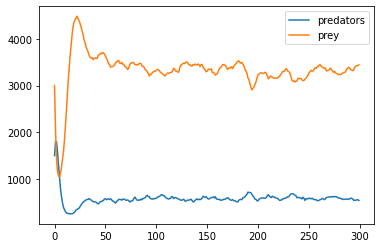

x1, x2, x3 error: 1517


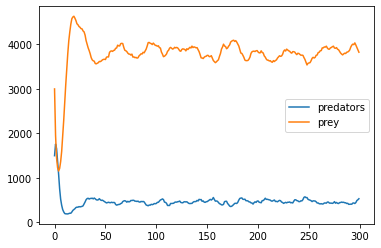

x1+h error: 2209


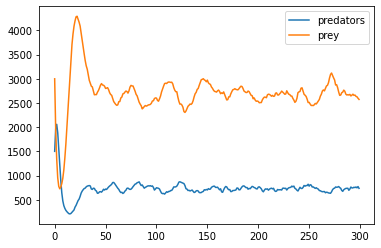

x2+h error: 1289


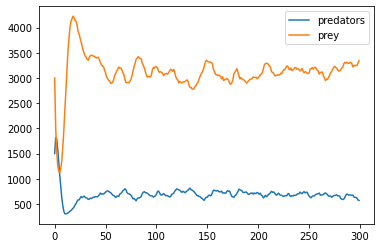

x3+h error: 1273
done running iteration


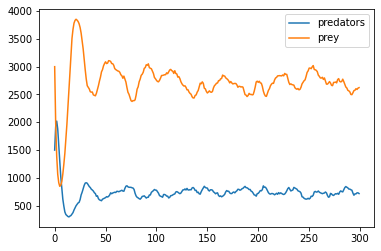

x1, x2, x3 error: 1277


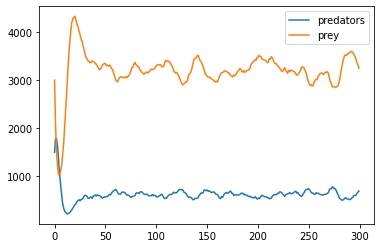

x1+h error: 1574


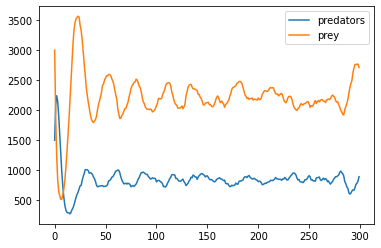

x2+h error: 1681


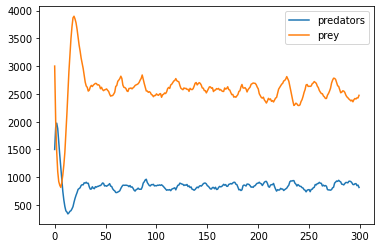

x3+h error: 1361
done running iteration


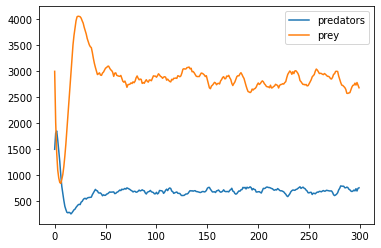

x1, x2, x3 error: 1190


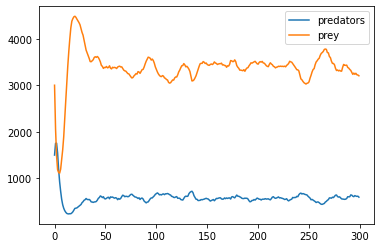

x1+h error: 1808


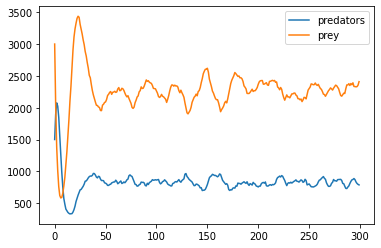

x2+h error: 1647


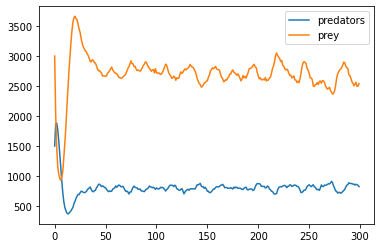

x3+h error: 1286
done running iteration


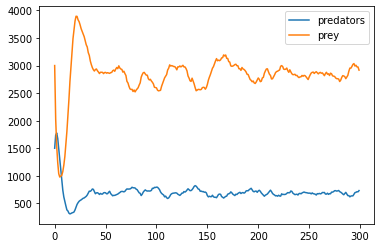

x1, x2, x3 error: 1202


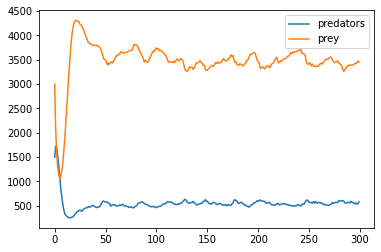

x1+h error: 1716


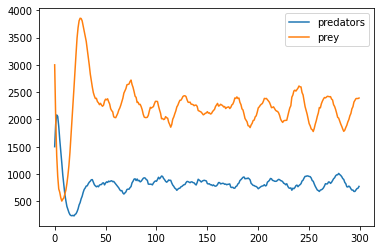

x2+h error: 1856


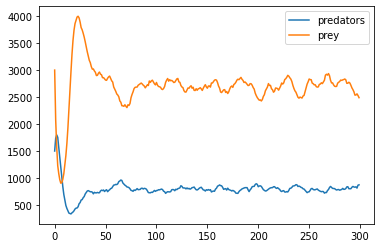

x3+h error: 1230
done running iteration


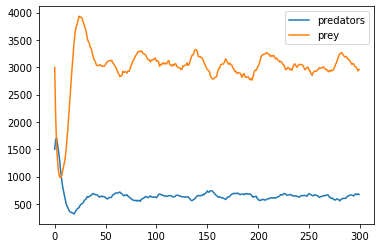

x1, x2, x3 error: 1190


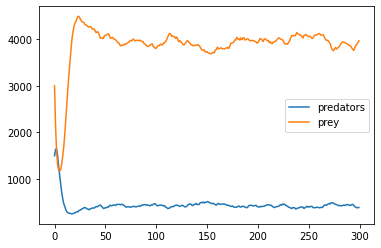

x1+h error: 2271


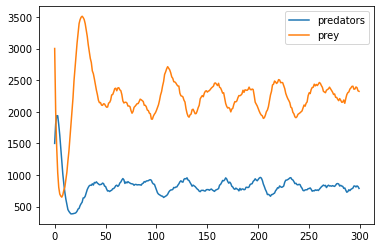

x2+h error: 1783


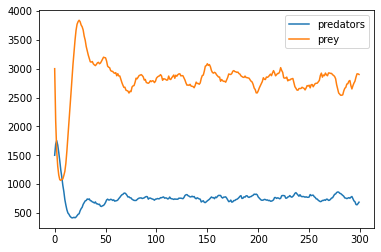

x3+h error: 1152
done running iteration



In [64]:
def run_abm(x1, x2, x3, n=300):
    return Model(x1, x2, x3, n).run_of()

def basic_robbins_monro_3d(x1, x2, x3, n=10):    
    h = 0.1
    x1l = []
    x2l = []
    x3l = []
    yl = []
    projections = 0
    
    for i in trange(n):
        a = 1/(10000*n)
#         with concurrent.futures.ThreadPoolExecutor() as executor:
#             t_x1 = executor.submit(run_abm, x1+h, x2, x3)
#             t_x2 = executor.submit(run_abm, x1, x2+h, x3)
#             t_x3 = executor.submit(run_abm, x1, x2, x3+h)
#             t_y = executor.submit(run_abm, x1, x2, x3)
            
#             x1_estimate = t_x1.result()
#             x2_estimate = t_x2.result()
#             x3_estimate = t_x3.result()
#             y = t_y.result()
            
            
        y = Model(x1, x2, x3, 300).run_of()
        print("x1, x2, x3 error:", y)
        yl.append(y)
        
        x1_estimate = Model(x1+h, x2, x3, 300).run_of()
        print("x1+h error:", x1_estimate)
        x2_estimate = Model(x1, x2+h, x3, 300).run_of()
        print("x2+h error:", x2_estimate)
        x3_estimate = Model(x1, x2, x3+h, 300).run_of()
        print("x3+h error:", x3_estimate)
        
        x1 = x1 - a*((x1_estimate - y)/h)
        x2 = x2 - a*((x2_estimate - y)/h)
        x3 = x3 - a*((x3_estimate - y)/h)
        
        if x1 < 0 or x1 > 1:
            x1 = np.random.rand()
            print("x1 random projection")
            projections += 1
        if x2 < 0 or x2 > 1:
            x2 = np.random.rand()
            print("x2 random projection")
            projections += 1
        if x3 < 0 or x3 > 1:
            x3 = np.random.rand()
            print("x3 random projection")
            projections += 1
        
        x1l.append(x1)
        x2l.append(x2)
        x3l.append(x3)
        print("done running iteration")
    return x1l, x2l, x3l, yl

x1s, x2s, x3s, ys = basic_robbins_monro_3d(0.02, 0.05, 0.2)

[2229, 5000, 5000, 5000, 5000, 1517, 1277, 1190, 1202, 1190]


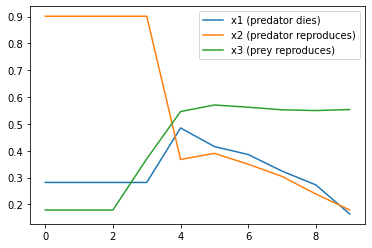

C:\Users\lverm\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


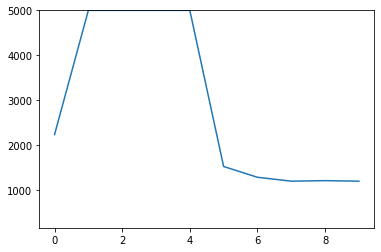

7


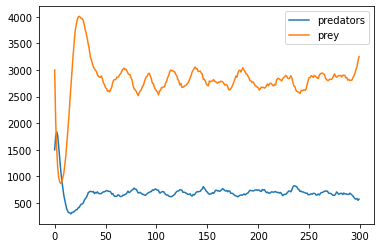

1223

In [69]:
# print(x1s, '\n', x2s, '\n', x3s, '\n', ys, '\n')
print(ys)
plt.plot(x1s, label="x1 (predator dies)")
plt.plot(x2s, label="x2 (predator reproduces)")
plt.plot(x3s, label="x3 (prey reproduces)")
plt.legend()
plt.show()

plt.plot(ys, label="y")
plt.axes().set_ylim(150, 5000)
plt.show()

i_min = ys.index(min(ys))
print(i_min)
Model(x1s[i_min], x2s[i_min], x3s[i_min], 300).run_of()

In [ ]:
def func1_list(x):
    return x**2 + np.random.normal(0, 5, len(x)) 

def func1(x):
    return x**2+np.random.normal(0, 2) 

x = np.arange(-10, 10, 0.1)
y = func1_list(x)
# plt.plot(x, y, 'o', markersize = 1)
# plt.show()
# hold on

def kw(f, starting_point, a, c, iterations=200):
    x = starting_point
    x_list = []
    y_list = []
    for i in range(iterations):
        if x > 1000 or x < -1000:
            break
#         print(x)
        x = x-a(f(x+c)-f(x-c))
        x_list.append(x)
        y_list.append(y)
    return x_list, y_list
        
# x_list, y_list = basic_robbins_monro(func1, -10, -0.005)
# plt.plot(x_list, y_list)

for i in range(10):
    kw(func1, -10, -0.005)

In [ ]:
# from multiprocessing import Process
import multiprocessing as mp

def f(x1, x2, x3):
    Model(x1, x2, x3, 300).run_of()

# if __name__ == '__main__':
#     mp.set_start_method('spawn')

q = mp.Queue()
p = mp.Process(target=f, args=(0.5, 0.5, 0.5))
p.start()
print(q.get())
p.join()

In [201]:
import os
print(os.cpu_count())

8
